# HW 4: a) Models fit to text data and b) Neural Networks

In [414]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import aimodelshare as ai
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import aimodelshare as ai
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
# nltk.download('punkt')
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import to_categorical

In [273]:
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

## Part 1: Build a classification model using text data

In [2]:
from aimodelshare import download_data
download_data('public.ecr.aws/y2e2a1d6/clickbait_competition_data-repository:latest')


Data downloaded successfully.


In [276]:
X=pd.read_csv("clickbait_competition_data/X_train.csv", squeeze=True)
y=pd.read_csv("clickbait_competition_data/y_train.csv", squeeze=True)
X_train, X_test, y_train_labels, y_test_labels = train_test_split(X, y, random_state=23)
# le = LabelEncoder()
# y = le.fit_transform(y) 
# y
# # one encode Y data (not necessary for logistic regression in sklearn
# # y_train = pd.get_dummies(y_train_labels)

# print(X.shape, y.shape)

In [290]:
# preprocess data
X_train_array=np.array(X_train)
X_test_array=np.array(X_test)
y_train_array=np.array(pd.get_dummies(y_train_labels)['clickbait'])
y_test_array=np.array(pd.get_dummies(y_test_labels)['clickbait'])

In [291]:
# print first 5 elements of X_train data and y_train_labels data
print(X_train_array[:5], '\n', y_train_array[:5])

['How Well Do You Actually Know The Laws Of Rugby'
 '22 Photos Guaranteed To Annoy Anyone Who Bakes'
 'Advice in Two New Books, but Not From Talking Heads'
 'Which Movie Starring A Pop Star Are You'
 '24 Adorable Products Every Cat Lover Needs In Their Home'] 
 [1 1 0 1 1]


In [292]:
# check the # of clickbaits and not clickbaits
pd.get_dummies(y_train_labels)['clickbait'].value_counts()

0    9626
1    9108
Name: clickbait, dtype: int64

In [296]:
# keep uni-gram only
cv1 = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1)).fit(X_train)
print("Vocabulary size: {}".format(len(cv1.vocabulary_)))
print("Vocabulary:\n{}".format(cv1.get_feature_names_out()))

Vocabulary size: 17548
Vocabulary:
['00' '000' '000th' ... 'île' 'ürümqi' 'šibenik']


In [297]:
# keep bi-grams only
cv2 = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(2, 2)).fit(X_train)
print("Vocabulary size: {}".format(len(cv2.vocabulary_)))
print("Vocabulary:\n{}".format(cv2.get_feature_names_out()))

Vocabulary size: 75139
Vocabulary:
['00 disney' '000 000' '000 acquitted' ... 'île france' 'ürümqi china'
 'šibenik 2008']


In [325]:
# keep uni-gram and bi-grams
cv3 = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2)).fit(X_train)
print("Vocabulary size: {}".format(len(cv3.vocabulary_)))
print("Vocabulary:\n{}".format(cv3.get_feature_names_out()))

Vocabulary size: 92687
Vocabulary:
['00' '00 disney' '000' ... 'ürümqi china' 'šibenik' 'šibenik 2008']


### I tried three different vectorizers:

1. CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1))
2. CountVectorizer(lowercase=True, stop_words='english', ngram_range=(2, 2))
3. TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2))

All three vectorizers lowercase words and exclude stopwords. However, the second vectorizer is different from the first one in that it is bi-grams. The third vectorizer is different from the first two in that it weights words frequency while others only count the number of times a word appears in the document without penalizing common words.

In [326]:
# helper function to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha='right')
    plt.ylabel('Coefficient magnitude')
    plt.xlabel('Feature')

Vectorizer: CountVectorizer(stop_words='english')
cross-validation score: 0.95
test score: 0.95


None

Vectorizer: CountVectorizer(ngram_range=(2, 2), stop_words='english')
cross-validation score: 0.78
test score: 0.81


None

Vectorizer: TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
cross-validation score: 0.93
test score: 0.95


None

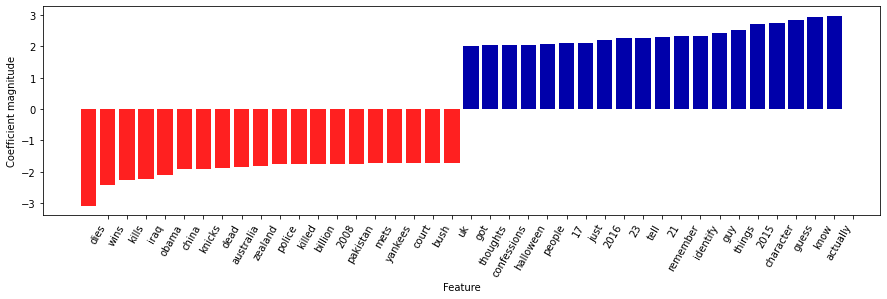

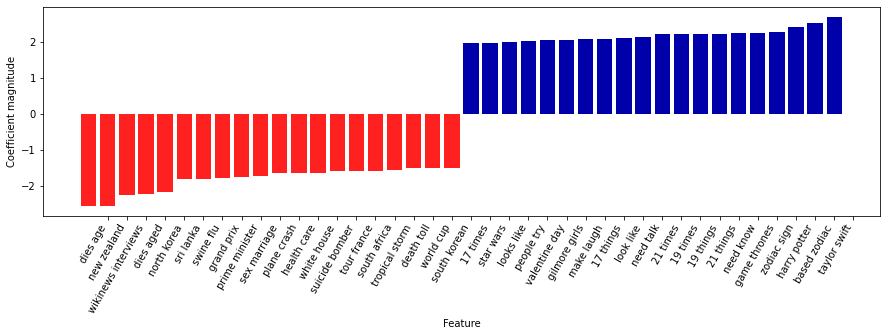

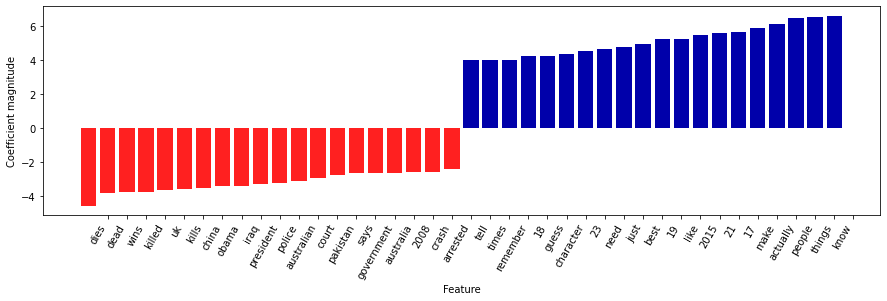

In [396]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# create a list of the vectorizers to feed into a for loop
vectorizers=[cv1, cv2, cv3]

for vect in vectorizers:
    X=vect.transform(X_train_array)
    X_test=vect.transform(X_test_array)
    scores=cross_val_score(LogisticRegression(), X, y_train_array, scoring='f1')
    print('Vectorizer:', vect)
    print('cross-validation score: {:.2f}'.format(np.mean(scores)))
    # Get the predictions
    lr=LogisticRegression().fit(X, y_train_labels_encoded_array)
    y_pred = lr.predict(X_test)
    print('test score: {:.2f}'.format(f1_score(y_test_array, y_pred)))
    coefs=lr.coef_
    feature_names=vect.get_feature_names()
    display(visualize_coefficients(coefs, feature_names, n_top_features=20))

Cross-validation, test scores, and 40 words most relevant features deciding a clickbait for each vectorization approchan are shown above.

#### [Vectorizer #1] 
- The first vectorizer (lowercasing all words, excluding stop words, and keeping uni-gram only) produces the cross-validation score of 0.95, and the test score of 0.95. Vectorizer 1 is the highest among the results in the three vectorization approaches.
- The most important predictor words for a clickbait in a logistic regression model using the first vectorizer are 'actually', 'know', and 'guess'. On the other hand, the most important predictor words for a not clickbait are 'dies', 'wins', and 'kills'.

#### [Vectorizer #2] 
- The second vectorizer (lowercasing all words, excluding stop words, and keeping bi-grams) produced the cross-validation score of 0.78, and the test score of 0.81. 
- The most important predictor words for a clickbait in a logistic regression model using the first vectorizer are 'taylor swift', 'based zodiac', and 'harry potter'. On the other hand, the most important predictor words for a not clickbait are 'dies age', 'new zealand', and 'kills'.

#### [Vectorizer #3] 
- The third vectorizer (lowercasing all words, excluding stop words, keeping uni-gram and bi-grams, and weighing words frequency) produced the cross-validation score of 0.93, and the test score of 0.95.
- The most important predictor words for a clickbait in a logistic regression model using the first vectorizer are 'know', 'things', and 'people'. On the other hand, the most important predictor words for a not clickbait are 'dies', 'dead', and 'wins'. 'actually', 'guess', and 'kills' are dropped in vectorizer 3 relative to vectorizer 1, which indicates that these words might occur much more frequently.

I would ultimately choose the vectorizer 3 not only because it produces the highest test scores, but also it is more reasonable to add weights to words frequency. Even though it is 0.02 less than vectorizer 1 in cross-validation, vectorizer 3 is also a good indicator.

## Part 2: Build a predictive neural network using Keras

In [421]:
# import data
iris = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv", index_col=0)
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [422]:
iris['Species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: Species, dtype: int64

In [423]:
# encode labels
le = LabelEncoder()
iris.Species = le.fit_transform(iris.Species) 
iris.Species.tail()

146    2
147    2
148    2
149    2
150    2
Name: Species, dtype: int32

In [424]:
# generate X and y
X = iris.drop('Species', axis=1)
y = iris.Species
# Split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
X_train.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
54,5.5,2.3,4.0,1.3
142,6.9,3.1,5.1,2.3
79,6.0,2.9,4.5,1.5
98,6.2,2.9,4.3,1.3
144,6.8,3.2,5.9,2.3


In [427]:
# standardize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[0:5]

array([[-0.47639181, -1.69145955,  0.08910607,  0.08782308],
       [ 1.2447657 ,  0.11276397,  0.72366489,  1.41703726],
       [ 0.1383073 , -0.33829191,  0.3775419 ,  0.35366592],
       [ 0.38418694, -0.33829191,  0.26216757,  0.08782308],
       [ 1.12182588,  0.33829191,  1.18516222,  1.41703726]])

In [436]:
model = Sequential([
    Dense(100, input_dim=4),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(3),
    Activation('softmax')
])
sgd = SGD(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
y_train_cat = to_categorical(y_train, 3)
y_test_cat = to_categorical(y_test, 3)
model.fit(X_train_scaled, y_train_cat,epochs=20, batch_size=128)
score = model.evaluate(X_test_scaled, y_test_cat, batch_size=128) # extract loss and accuracy from test data evaluation
print(f'score: {score}')

Epoch 1/20
1/1 [==============================] - 0s 283ms/step - loss: 0.9749 - accuracy: 0.6071
Epoch 2/20
1/1 [==============================] - 0s 4ms/step - loss: 0.9740 - accuracy: 0.6071
Epoch 3/20
1/1 [==============================] - 0s 3ms/step - loss: 0.9732 - accuracy: 0.6161
Epoch 4/20
1/1 [==============================] - 0s 5ms/step - loss: 0.9723 - accuracy: 0.6250
Epoch 5/20
1/1 [==============================] - 0s 3ms/step - loss: 0.9715 - accuracy: 0.6339
Epoch 6/20
1/1 [==============================] - 0s 3ms/step - loss: 0.9706 - accuracy: 0.6339
Epoch 7/20
1/1 [==============================] - 0s 5ms/step - loss: 0.9698 - accuracy: 0.6429
Epoch 8/20
1/1 [==============================] - 0s 5ms/step - loss: 0.9689 - accuracy: 0.6429
Epoch 9/20
1/1 [==============================] - 0s 4ms/step - loss: 0.9681 - accuracy: 0.6429
Epoch 10/20
1/1 [==============================] - 0s 4ms/step - loss: 0.9672 - accuracy: 0.6429
Epoch 11/20
1/1 [====================

In [431]:
# model 2
model = Sequential([
    Dense(200, input_dim=4),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(3),
    Activation('softmax')
])
sgd = SGD(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
y_train_cat = to_categorical(y_train, 3)
y_test_cat = to_categorical(y_test, 3)
model.fit(X_train_scaled, y_train_cat,epochs=20, batch_size=128)
score = model.evaluate(X_test_scaled, y_test_cat, batch_size=128) # extract loss and accuracy from test data evaluation
print(f'score: {score}')
# X_train_scaled.shape

Epoch 1/20
1/1 [==============================] - 0s 312ms/step - loss: 1.2208 - accuracy: 0.2946
Epoch 2/20
1/1 [==============================] - 0s 6ms/step - loss: 1.2197 - accuracy: 0.2946
Epoch 3/20
1/1 [==============================] - 0s 5ms/step - loss: 1.2186 - accuracy: 0.2946
Epoch 4/20
1/1 [==============================] - 0s 6ms/step - loss: 1.2176 - accuracy: 0.2946
Epoch 5/20
1/1 [==============================] - 0s 6ms/step - loss: 1.2165 - accuracy: 0.2946
Epoch 6/20
1/1 [==============================] - 0s 6ms/step - loss: 1.2154 - accuracy: 0.2946
Epoch 7/20
1/1 [==============================] - 0s 6ms/step - loss: 1.2143 - accuracy: 0.3036
Epoch 8/20
1/1 [==============================] - 0s 5ms/step - loss: 1.2132 - accuracy: 0.3036
Epoch 9/20
1/1 [==============================] - 0s 6ms/step - loss: 1.2122 - accuracy: 0.3125
Epoch 10/20
1/1 [==============================] - 0s 6ms/step - loss: 1.2111 - accuracy: 0.3125
Epoch 11/20
1/1 [====================

The result above shows that among the two values, 100 and 200, I tried for the number of hidden nodes in each layer. 100 hidden node displays loss of 0.95 and accuracy of 0.71. On the other hand, 200 hidden node displays loss of 1.20 and accuracy of 0.26. The value of 100 produces the better score with lower loss and high accracy, implies a low risk of overfitting.